# Scanpy: Preprocessing and clustering 3k PBMCs

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

## Load data

In [ ]:
# Load data
mkdir data
wget "http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz" -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
mkdir write

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [21]:
results_file = '/Users/liaoyj/Documents/Rubalind/data/write/pbmc3k.h5ad'  # the file that will store the analysis results

Read in count mtx as AnnData object
- slots for annotations + diff representations of data
- HDF5-based file format `.h5ad`
    - https://www.hdfgroup.org/solutions/hdf5/

In [5]:
adata = sc.read_10x_mtx(
    '/Users/liaoyj/Documents/Rubalind/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... writing an h5ad cache file to speedup reading next time


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

Show genes that yield highest fraction of counts in each single cell, across all cells

normalizing counts per cell
    finished (0:00:00)


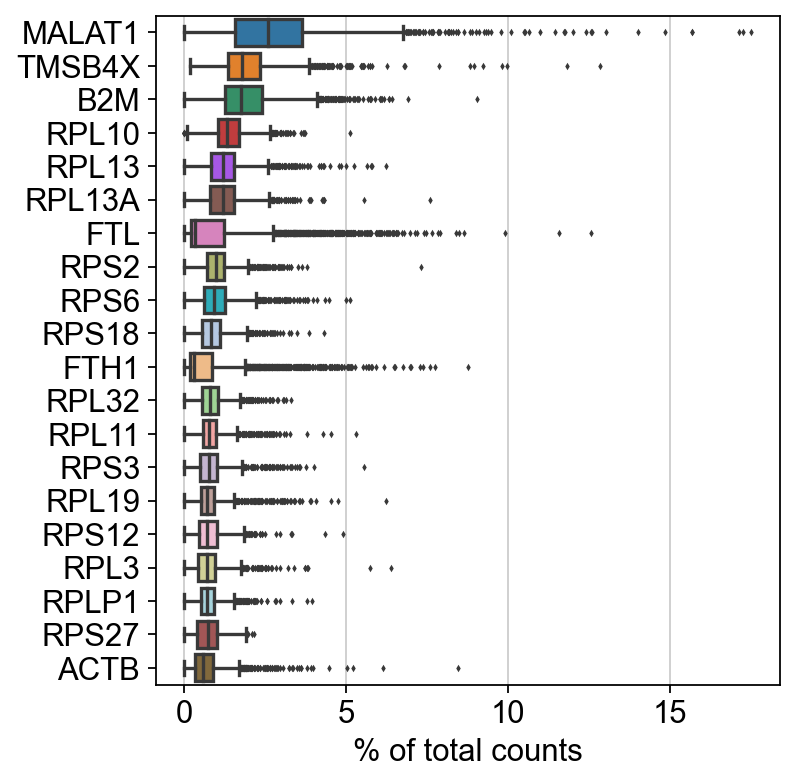

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


Mitochondrial filtering

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):
>High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

QC violin plots
- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in mitochondrial genes

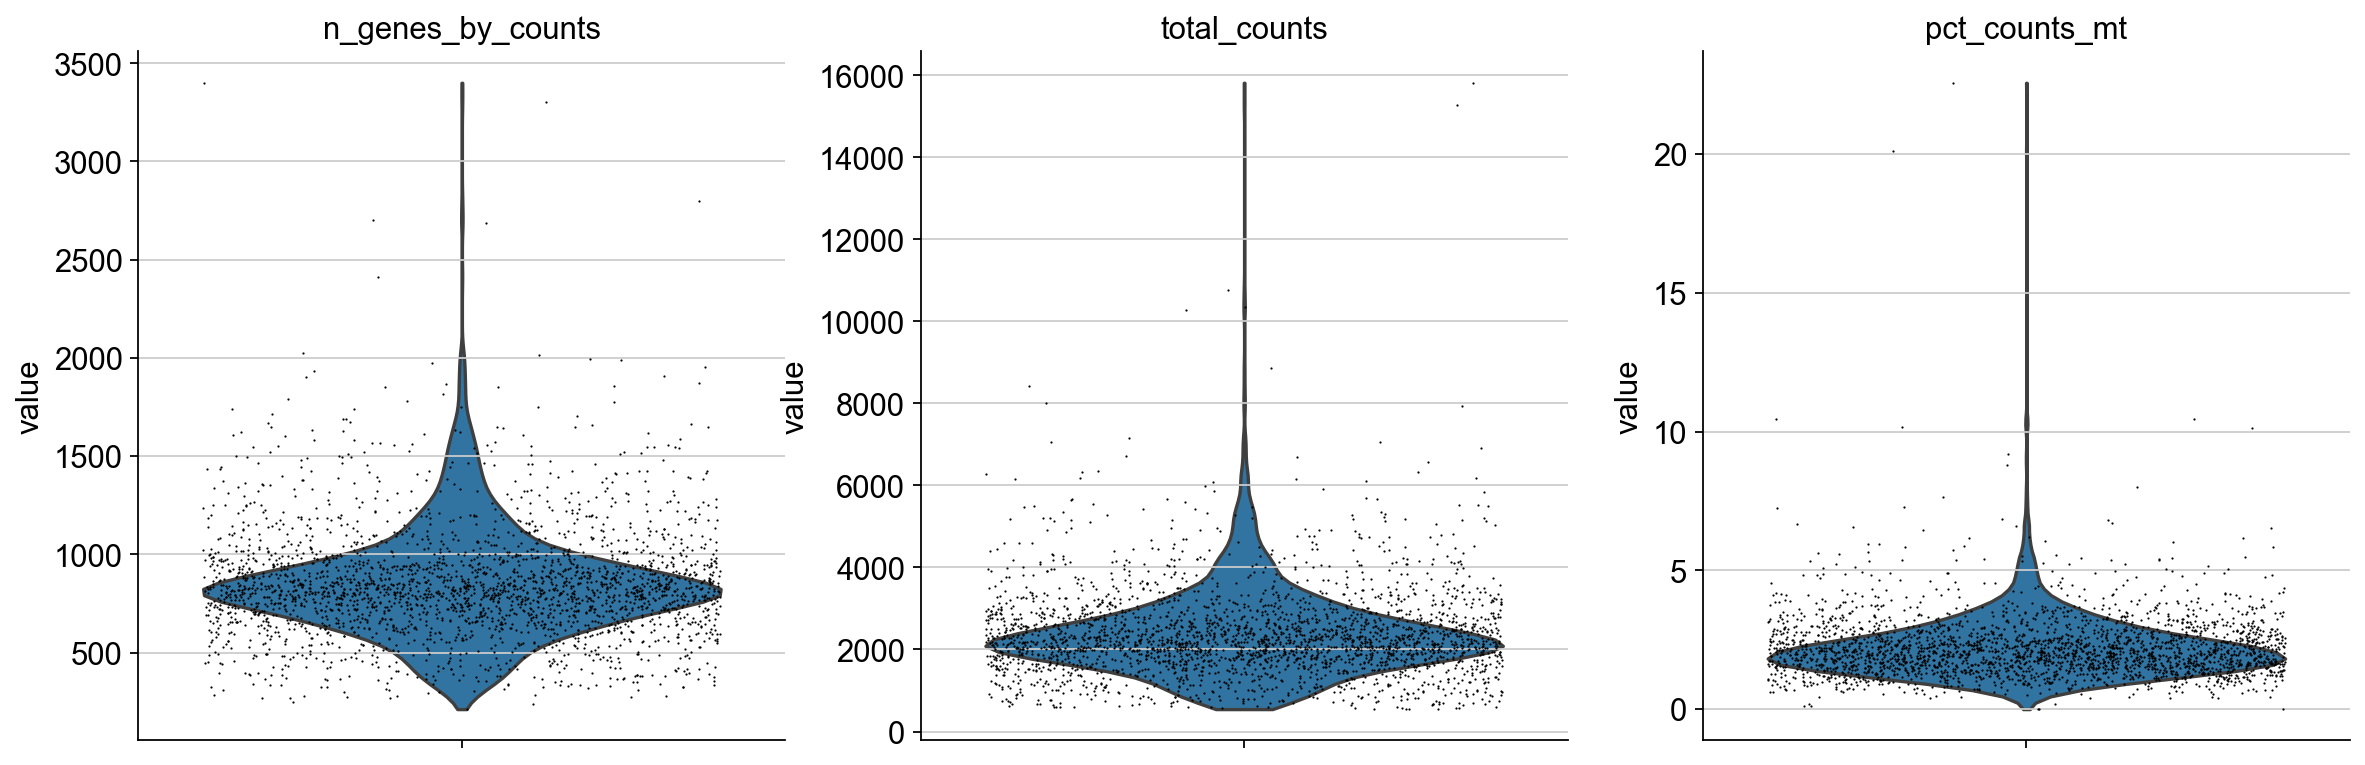

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

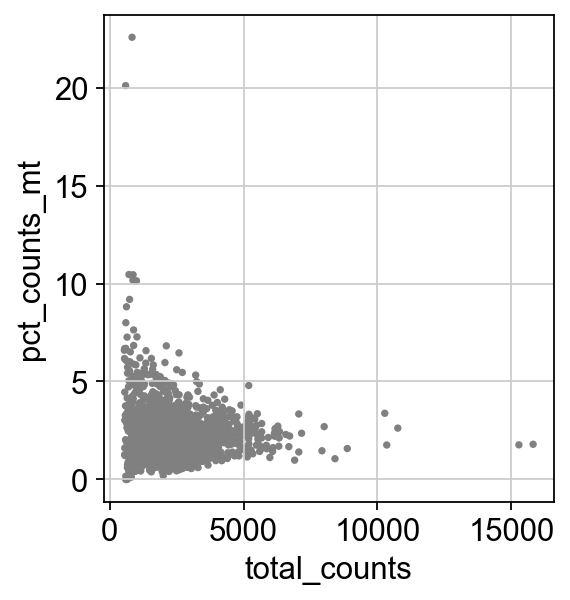

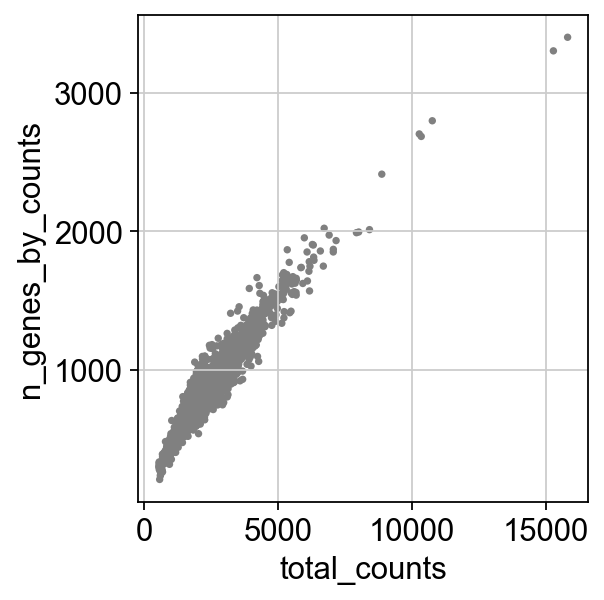

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
# Do the filtering by slicing the AnnData object
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [15]:
# Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell,
# so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)
# Log transform
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


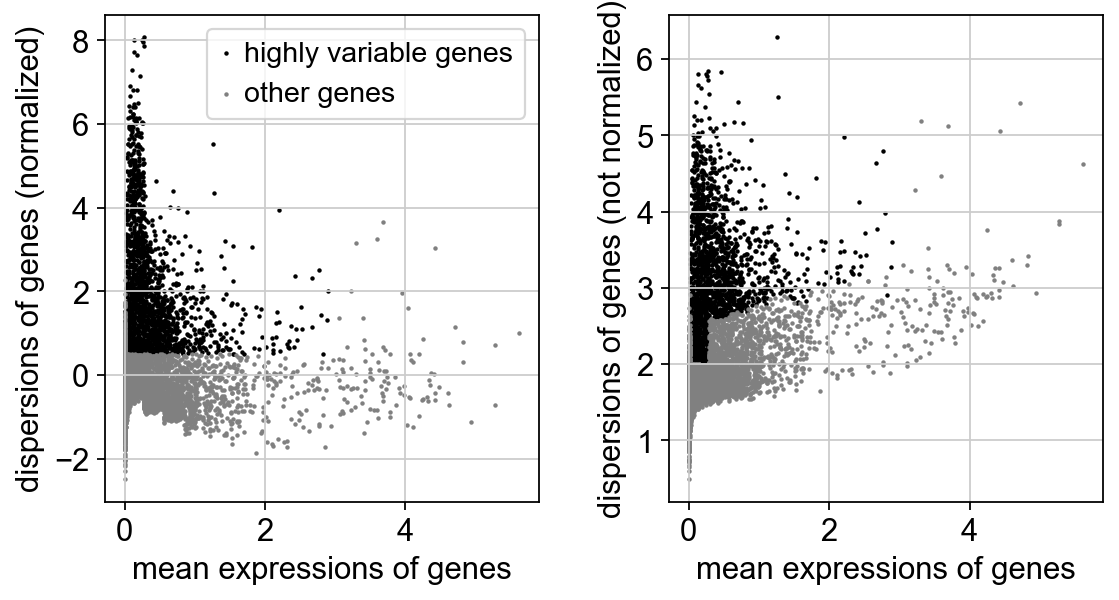

In [16]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Plot highly-variable genes
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
- can get back `AnnData` of object in `.raw` by calling `.raw.to_adata()`

NOTE
If you don’t proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step actually do the filtering below is unnecessary, too.

In [17]:
adata.raw = adata

In [ ]:
# Actually do the filtering
adata = adata[:, adata.var.highly_variable]
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
# Scale the data to unit variance.
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

## PCA

In [18]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


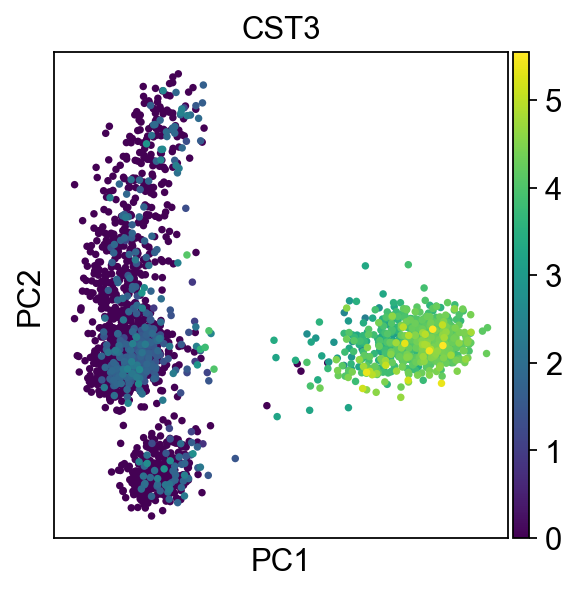

In [19]:
# PCA scatter
sc.pl.pca(adata, color='CST3')

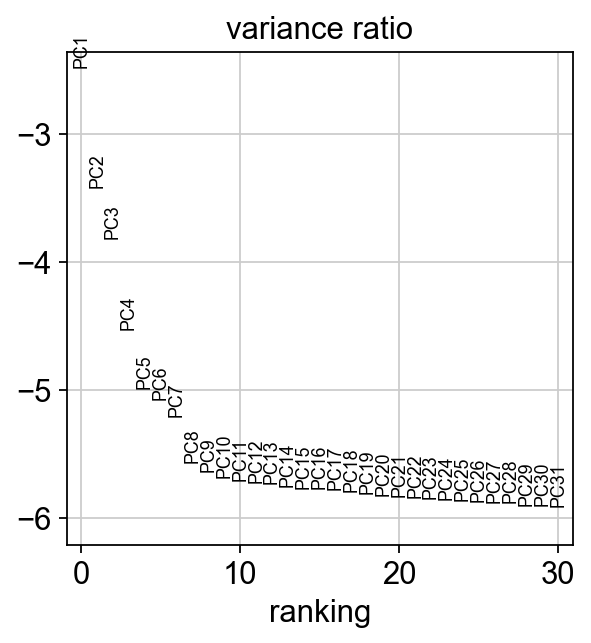

In [20]:
# Screeplot / PC contribution to total data variance
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
# Save results
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

In [23]:
# Neighbors w/ Seurat tutorial values
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


## Embedding neighborhood graph

UMAP suggestion over tSNE - more faithful to global connectivity of manifold, better preserves trajectories

If still disconnected clusters + connectivity violations, can fix w/
```
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
```

In [24]:
# Run UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


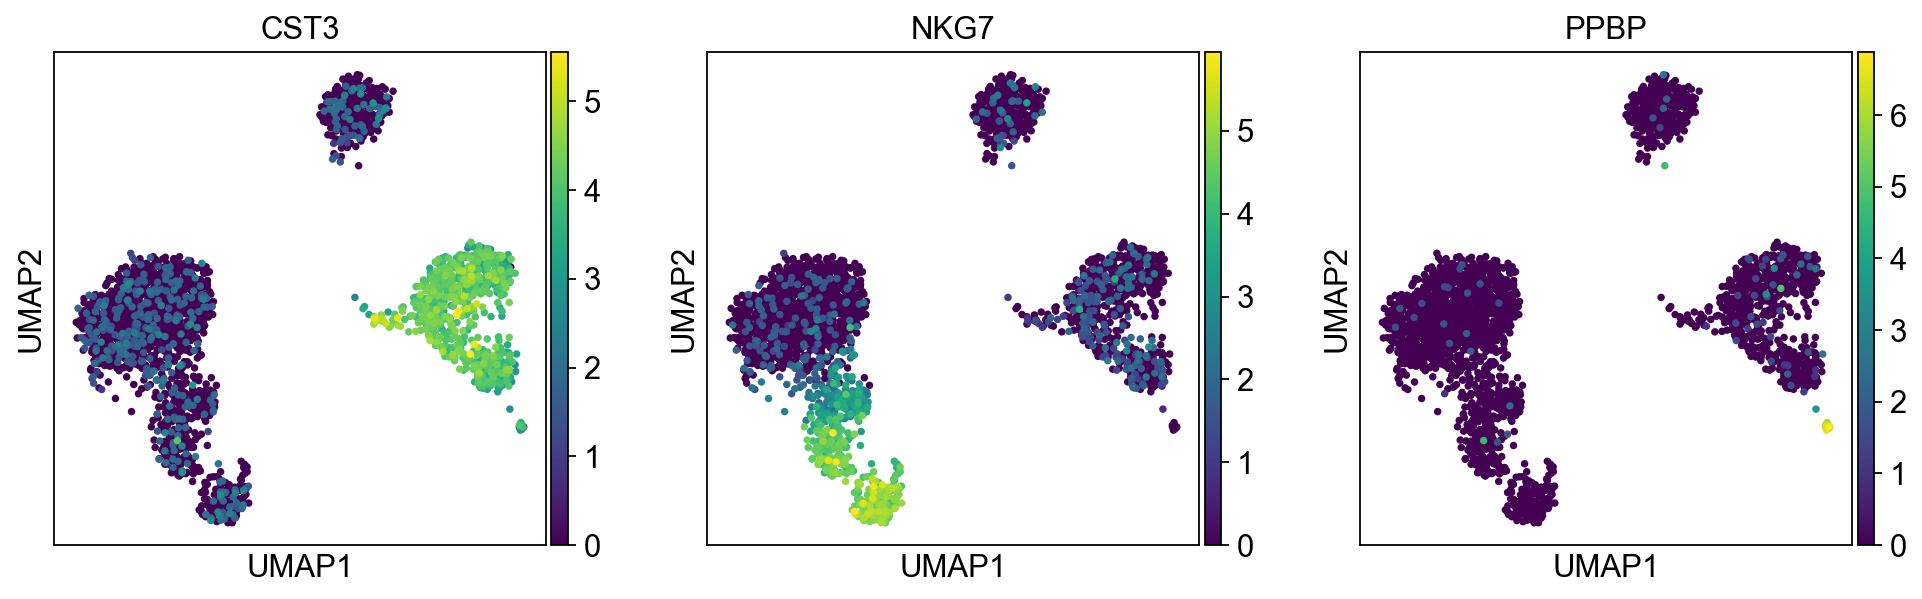

In [25]:
# UMAP gene expression (raw: normalized, logged, uncorrected)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

## Clustering the neighborhood graph

Leiden graph-clustering method recommended
- community detection based on optimizing modularity
- [Traag et al. 2018](https://www.nature.com/articles/s41598-019-41695-z)
- directly clusters neighborhood graph of cells -> computed in prev section

In [26]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/liaoyj/mambaforge/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


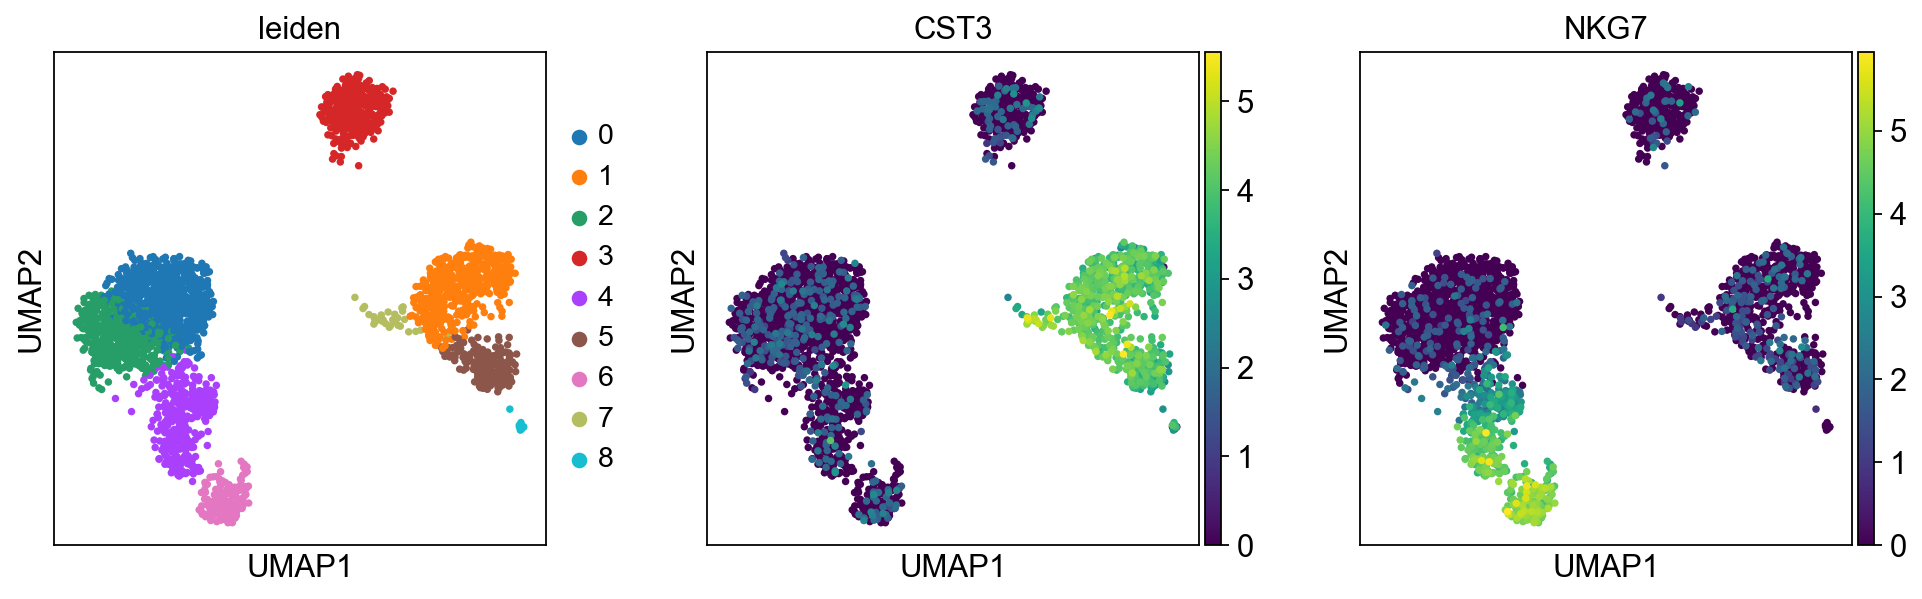

In [27]:
# Plot clusters
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [28]:
# Save result
adata.write(results_file)

## Finding marker genes

https://scanpy.readthedocs.io/en/latest/tutorials/pbmc3k.html#finding-marker-genes